# Machine Learning for EM Data Classification

This notebook includes the following activities.

- High-level use of SVM and neural network classifiers.
- Classifying dummy signal data
- Classifying real EM data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from emvincelib import iq, ml, stat
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from scipy.fftpack import fft
from sklearn import preprocessing

%matplotlib inline

### 1. Machine Learning Concepts

Machine Learning (ML) is a broad domain that develops various algorithms and statistical models to learn patterns from data and later make predictions. It is not possible to learn ML within this workshop. However, in this Jupyter-Notebook, we'll look at the basic concepts of ML and how it can help us to learn patterns in EM data. Machine Learning can be categorized into two types as **supervised** and **unsupervised** learning. In supervised learning, we provide example data and their expected classification output to an algorithm to learn. Once learned, the algorithm can produce classification output for new data. In unsupervised learning, we only provide data so that the algorithm learn patterns on its own and become capable of classifying new data.

When performing ML on EM data, supervised learning is the approach we need to focus on. We can provide example EM data for specific known things occuring on computing devices and train ML models to recognize similar activities when given unknown EM data. The training data are provided in a 2-D array format named as **X**. The target classification classes for the input data are in a 1-D array named as **y**. Towards this goal, let's focus on the following two supervised ML architectures for time being.

   1. Support vector machines (SVM)
   2. Neural networks

#### Support Vector Machines

![alt text](./images/svm-intro.png "Support vector machines (SVM)")


Reference: https://scikit-learn.org/stable/modules/svm.html



In [2]:
X = [[0., 0.], [1., 1.]]
y = [0, 1]

clf = svm.SVC()

clf.fit(X, y)

clf.predict([[2., 2.], [-1., -2.]])

array([1, 0])

#### Neural Networks

![alt text](./images/neural-network-intro.png "Neural Networks")

Reference: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [3]:
X = [[0., 0.], [1., 1.]]
y = [0, 1]

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)

clf.predict([[2., 2.], [-1., -2.]])

array([1, 0])

### 2. Pre-processing Signals for Machine Learning

We cannot directly use EM data files we have acquired as input to an ML model. We have to pre-process our EM data files and build the **X** and **y** data structures. Let's learn it by using a dummy dataset. Following GRC flowgraph emulates two signals that are being generated with different frequency components. Our task is to train a ML model that can distinquish between the two signal sources when a new signal file is provided.

![alt text](./images/4.data-source.png "Flowgraph to generate two data files")

#### Dataset

You can find the two data files called **4.training-class-1.cfile** and **4.training-class-2.cfile** in the data folder. Let's see the basics details about these two data files.

In [4]:
file1="./data/4.training-class-1.cfile"
file2="./data/4.training-class-2.cfile"

In [5]:
iq.sampleRate = 32e3

duration1 = iq.getTimeDuration(file1, fileType="cfile")                      
print("Time duration of the cfile file: " + str(duration1) + " seconds")

data1 = iq.getData(file1)
length = len(data1)
print("Number of samples in cfile data: " + str(length))

Time duration of the cfile file: 53.104 seconds
Number of samples in cfile data: 1699328


In [6]:
duration2 = iq.getTimeDuration(file2, fileType="cfile")                       
print("Time duration of the cfile file: " + str(duration2) + " seconds")

data2 = iq.getData(file2)
length = len(data2)
print("Number of samples in cfile data: " + str(length))

Time duration of the cfile file: 53.104 seconds
Number of samples in cfile data: 1699328


Let's visualize them and see if we can visually recognize differences between the two signals.

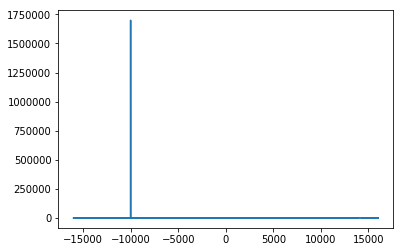

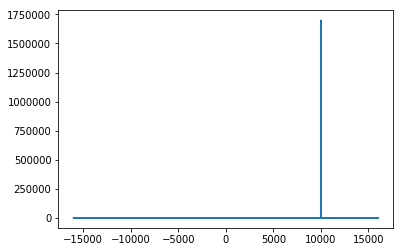

1

In [7]:
iq.plotFFT(data1)

iq.plotFFT(data2)

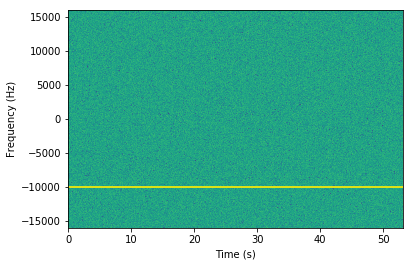

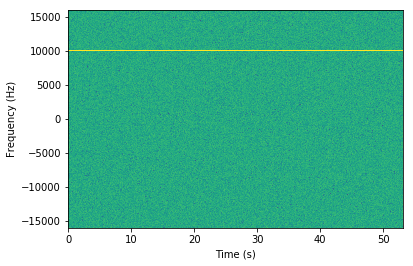

1

In [8]:
iq.plotSpectrogram(data1)

iq.plotSpectrogram(data2)

#### Generating training dataset

We can clearly see from the FFT plots that the frequency components of the two signals are different. That means, at the frequency domain, we can distinquish between them. Now, in order to train an ML model, we need many frequency domain signals for each class. The easiest way to produce many signals from the original files is extracting smaller data segments from the files. Following code block illustrates taking a 10 milliseconds long segment from the beginning of each file and checking how many samples we have taken into that segment.

In [9]:
data_segment_cfile = iq.getSegmentData(file1, 0, 0.01)

length = len(data_segment_cfile)

print("Number of samples in cfile data: " + str(length))

Number of samples in cfile data: 320


Now, the extracted data segment can be converted to frequency domain using FFT. However, the FFT vector will still be long with about 320 features. We can reduce the number of features further down by averaging data into a smaller number of buckets. The **emvince** library provides a single function that facilitates that called **getFeatureVector()** where the first parameter is the extracted data segment and the second parameter is the number of features we want. Let's set it to something like 50 features.

We can plot the resulting feature vector for this data segment in order to better see how it look like. As you will see, we have just 50 features in x-axis now and the amplitude has been normalized to a value between 0 and 1.

50


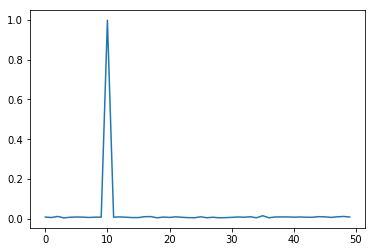

In [10]:
feature_vector = ml.getFeatureVector(data_segment_cfile, featureVectorSize=50)
print(len(feature_vector))

plt.figure()
plt.plot(feature_vector)
plt.show()

Similarly, let's take a segment from the other data file and create a feature vector for that.

In [11]:
data_segment_cfile = iq.getSegmentData("./data/4.training-class-2.cfile", 0, 0.01)

length = len(data_segment_cfile)

print("Number of samples in cfile data: " + str(length))

Number of samples in cfile data: 320


50


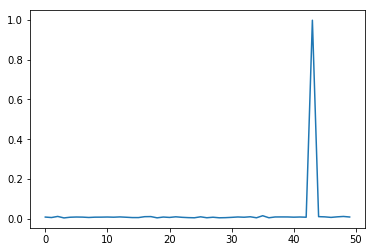

In [12]:
feature_vector = ml.getFeatureVector(data_segment_cfile, featureVectorSize=50)
print(len(feature_vector))

plt.figure()
plt.plot(feature_vector)
plt.show()

### 3. Training and Testing a Machine Learning Model

With these insights we have gained during the previous step, now we can generate the **X** and **y** training dataset for a classifier. We do that by sending a sliding window over the data files and converting each window data segment into a feature vector. Each feature vector is appended to the **X** matrix along with the appropriate label for it in the **y** vector.

In [13]:
X = []
Y = []

sliding_window_size = 0.01

Let's add the training samples from the first data file into the **X** and **y** variables. Notice that we set the class label as **Class 1** here.

In [14]:
duration = iq.getTimeDuration(file1, fileType="cfile") 

offset = 0

while (offset + sliding_window_size) < duration:
    segment = iq.getSegmentData(file1, offset, sliding_window_size)
    segment = np.nan_to_num(segment)
    feature_vector = ml.getFeatureVector(segment, featureVectorSize=50)
    
    X.extend([feature_vector])
    Y.append("Class 1")
    
    offset = offset + sliding_window_size

/home/asanka/Downloads/Jupyter-Notebooks/emvincelib/iq.py:278: RuntimeWarning: invalid value encountered in multiply
  data = data[0::2] + 1j*data[1::2]
/home/asanka/Downloads/Jupyter-Notebooks/emvincelib/iq.py:278: RuntimeWarning: invalid value encountered in add
  data = data[0::2] + 1j*data[1::2]
/home/asanka/Downloads/Jupyter-Notebooks/emvincelib/ml.py:25: RuntimeWarning: overflow encountered in absolute
  fftdata = np.abs(new_yf)


Let's add the training samples from the second data file into the **X** and **y** variables. Notice that we set the class label as **Class 2** here.

In [15]:
duration = iq.getTimeDuration(file2, fileType="cfile") 

offset = 0

while (offset + sliding_window_size) < duration:
    segment = iq.getSegmentData(file2, offset, sliding_window_size)
    segment = np.nan_to_num(segment)
    feature_vector = ml.getFeatureVector(segment, featureVectorSize=50)
    
    X.extend([feature_vector])
    Y.append("Class 2")
    
    offset = offset + sliding_window_size

We can create a neural network classifier, train it and test with the following functions. It results in a confusion matrix and classification report.

In [16]:
clf = ml.createClassifier()
ml.trainAndTest(clf, X, Y)

[[1145  153]
 [ 483  874]]
             precision    recall  f1-score   support

    Class 1       0.70      0.88      0.78      1298
    Class 2       0.85      0.64      0.73      1357

avg / total       0.78      0.76      0.76      2655

